# Calculate Skill of WACCM Forecasts for Precipitation

In [1]:
import xarray as xr
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import glob

### Data prepocessing function to handle occasional fcst files with missing data or not enough times

In [2]:
def preproc(ds):
    

    if (len(ds['time'])<34):
              
        ds['lat']=(np.arange(-90,91))
        
        tmpdata=np.zeros((34,len(ds['lat']),len(ds['lon'])))
        tmpdata[:,:,:]=np.nan
        ds_tmp=xr.DataArray(tmpdata,
                            coords={'time': np.arange(0,34).astype('float64'), 
                                    'lat':ds['lat'].astype('float32'),
                                    'lon': ds['lon'].astype('float32')},
                            dims=['time', 'lat','lon'])        
        ds=ds_tmp.to_dataset(name='pr')
        
    else:                          
        ds=ds.isel(time=slice(0,34))
    
    return ds

### Calculate Anomalies for WACCM hindcasts

In [3]:
# File Path information
model='CESM1_30LCAM5'
path='/glade/scratch/jrichter/CPC_DATA/'+model
dstr='00z_d01_d45'

# Variable to be processed
varname='pr'
lev='sfc'

# Years to be gotton
sdate='19990106' # This was set by hand as the first init date for the first year
edate='20151231'
yrs_list=np.arange(1999,2016)

# Initialization months
mnums=['01','02','12']
mstrs=['jan','feb','dec']


# Ensemble members
enss=['00','01','02','03','04'] 

### Read the data for the selected months and years for a given ensemble member. Combine all the data together for all inits

In [4]:
# Create empty list to append data for each ensemble member
fcst_ds_ens=[]

# Loop over ensembles
for iens in enss:

    # Create empty list to append data for each month
    fcst_ds_months=[]
    
    # Get list of files and read in data for each month for this ensemble member
    for mnum,mstr in zip(mnums,mstrs):
        
        # Get all the filenames for this month for all years
        fnames = [f'{path}/{varname}/{year}/{mnum}/{varname}_{lev}_{model}_*{mstr}{year}_{dstr}_m{iens}.nc' for year in yrs_list]       
        
        # Create list of all filenames for this ensemble member, month, and all years
        files1=[]
        for files in fnames:
            f2=glob.glob(files)
            for f in f2:
                files1.append(f)
       
        print(files1)
        
        # Read in data concatentating over the init dimension
        fcst_ds_tmp=xr.open_mfdataset(files1,parallel=True,combine='nested',
                                      decode_times=False,concat_dim='init')

        
        # Create dates for the init dimension and assign them
        init_dates_all=pd.date_range(start=sdate,end=edate,freq='7D')
        djf_dates=init_dates_all[(init_dates_all.month==int(mnum))]
        print("TEST: ",djf_dates)
        fcst_ds_tmp['init']=djf_dates

        # Append the latest month to the list
        fcst_ds_months.append(fcst_ds_tmp)
        
    
    # Combine the months into the init dimension
    fcst_ds_months = xr.combine_nested(fcst_ds_months, concat_dim=['init'])
    
    # Append this ensenble member
    fcst_ds_ens.append(fcst_ds_months)
    
    
fcst_ds_ens   

['/glade/scratch/jrichter/CPC_DATA/CESM1_30LCAM5/pr/1999/01/pr_sfc_CESM1_30LCAM5_06jan1999_00z_d01_d45_m00.nc', '/glade/scratch/jrichter/CPC_DATA/CESM1_30LCAM5/pr/1999/01/pr_sfc_CESM1_30LCAM5_27jan1999_00z_d01_d45_m00.nc', '/glade/scratch/jrichter/CPC_DATA/CESM1_30LCAM5/pr/1999/01/pr_sfc_CESM1_30LCAM5_13jan1999_00z_d01_d45_m00.nc', '/glade/scratch/jrichter/CPC_DATA/CESM1_30LCAM5/pr/1999/01/pr_sfc_CESM1_30LCAM5_20jan1999_00z_d01_d45_m00.nc', '/glade/scratch/jrichter/CPC_DATA/CESM1_30LCAM5/pr/2000/01/pr_sfc_CESM1_30LCAM5_05jan2000_00z_d01_d45_m00.nc', '/glade/scratch/jrichter/CPC_DATA/CESM1_30LCAM5/pr/2000/01/pr_sfc_CESM1_30LCAM5_26jan2000_00z_d01_d45_m00.nc', '/glade/scratch/jrichter/CPC_DATA/CESM1_30LCAM5/pr/2000/01/pr_sfc_CESM1_30LCAM5_19jan2000_00z_d01_d45_m00.nc', '/glade/scratch/jrichter/CPC_DATA/CESM1_30LCAM5/pr/2000/01/pr_sfc_CESM1_30LCAM5_12jan2000_00z_d01_d45_m00.nc', '/glade/scratch/jrichter/CPC_DATA/CESM1_30LCAM5/pr/2001/01/pr_sfc_CESM1_30LCAM5_17jan2001_00z_d01_d45_m00.nc', 

[<xarray.Dataset>
 Dimensions:  (LAT: 181, LON: 360, TIME: 45, init: 220)
 Coordinates:
   * LON      (LON) float32 0.0 1.0 2.0 3.0 4.0 ... 355.0 356.0 357.0 358.0 359.0
   * TIME     (TIME) float32 0.5 1.5 2.5 3.5 4.5 5.5 ... 40.5 41.5 42.5 43.5 44.5
   * LAT      (LAT) float32 -90.0 -89.0 -88.0 -87.0 -86.0 ... 87.0 88.0 89.0 90.0
   * init     (init) datetime64[ns] 1999-01-06 1999-01-13 ... 2015-12-30
 Data variables:
     PR       (init, TIME, LAT, LON) float32 dask.array<chunksize=(1, 45, 181, 360), meta=np.ndarray>
 Attributes:
     institution_id:  NCAR and NOAA/ESRL/PSD
     institution:     National Center for Atmospheric Research and NOAA Earth ...
     experiment_id:   Wed Nov 29 12:54:30 MST 2017
     model_id:        CESM1_30LCAM5
     frequency:       daily
     project_id:      SUBx project
     experiment:      1999-01-06 IC Sub-seasonal Forecast
     modeling_realm:  atmos
     realization:     000
     contact:         Jadwiga (Yaga) Richter (jrichter@ucar.edu), Judith

In [5]:
# Combine data over ensemble dimension
fcst_ds_ens = xr.combine_nested(fcst_ds_ens, concat_dim=['ens'])
fcst_ds_ens['ens']=np.arange(0,len(enss))

In [6]:
# Make ensemble mean
fcst_ds=fcst_ds_ens.mean(dim='ens')
del fcst_ds_ens

In [7]:
# Determine leads and set them as integers 
nt=fcst_ds['TIME'].size
leads=np.arange(0,nt)
fcst_ds=fcst_ds.rename({'TIME':'lead','LAT':'lat','LON':'lon','PR':varname})
fcst_ds['lead']=leads

In [8]:
base_path='/glade/scratch/kpegion/ESPWG/data/'

In [9]:
# Read Forecast Climatology
climo_path=base_path+model+'/hcst/climo/'
climo_fcst_fname=climo_path+'climo_'+varname+'.nc'
climo_fcst=xr.open_dataset(climo_fcst_fname,decode_times=True)

In [10]:
# Calculate Forecast Anomalies
anoms_fcst=fcst_ds.groupby('init.dayofyear')-climo_fcst

### Get the verification anomalies for forecasts from the fcst init dates

In [11]:
varname2='pr'
verif_path=base_path+'verif/'
verif_dataset='CPC-PRECIP'

In [12]:
# Create files names for verification data
verif_files = [f'{verif_path}{varname2}/daily/{verif_dataset}/orig/precip.{year}.nc' for year in range(1999, 2016)]

In [13]:
# Read in verif data for 1999-2015
verif_ds=xr.open_mfdataset(verif_files,decode_times=True,combine='by_coords',
                            parallel=True)  

# Rename precip to pr so forecast and verification have same variable name
verif_ds=verif_ds.rename({'precip':varname})

In [14]:
# Read Verification Climatology
verif_climo_path=verif_path+varname2+'/daily/'+verif_dataset+'/climo/'
climo_verif_fname=verif_climo_path+'climo_'+verif_dataset+'_'+varname2+'.nc'
climo_verif=xr.open_dataset(climo_verif_fname,decode_times=True)

In [15]:
# Calculate Verification Anomalies
anoms_verif=verif_ds.groupby('time.dayofyear')-climo_verif

In [16]:
# Interpolate verification to fcst 1x1 grid
verif1x1=anoms_verif.interp_like(climo_fcst)

In [17]:
# Rechunk time to make dask happy
verif1x1=verif1x1.chunk({'time':-1})

### Make Weekly Averages for Forecast and Verification

In [18]:
fcstweekly=anoms_fcst.rolling(lead=7,center=False).mean().dropna(dim='lead')

In [19]:
verifweekly=verif1x1.rolling(time=7,center=False,min_periods=1).mean().dropna(dim='time',how='all')

/glade/u/home/kpegion/miniconda3/envs/myenv/lib/python3.6/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


In [20]:
nleads=fcstweekly['lead'][::7].size
fcstweeklyda=xr.DataArray(fcstweekly[varname2][:,::7,:,:]*86400,
                           coords={'init' : fcstweekly['init'],
                                   'lead': np.arange(1,nleads+1),
                                   'lat' : fcstweekly['lat'],
                                   'lon' : fcstweekly['lon']
                                   },
                           dims=['init', 'lead','lat','lon'])
fcstweeklyda.name = varname2
fcstweeklyda['lead'].attrs={'units': 'weeks'}
del fcstweekly

### Calculate skill using `climpred`

In [21]:
from climpred import HindcastEnsemble
import climpred

In [22]:
hindcast = HindcastEnsemble(fcstweeklyda)
hindcast = hindcast.add_observations(verifweekly, 'obs')

In [23]:
skill = hindcast.verify(metric='acc')
skill

<xarray.Dataset>
Dimensions:  (lat: 181, lead: 6, lon: 360)
Coordinates:
  * lat      (lat) float32 -90.0 -89.0 -88.0 -87.0 -86.0 ... 87.0 88.0 89.0 90.0
  * lon      (lon) float32 0.0 1.0 2.0 3.0 4.0 ... 355.0 356.0 357.0 358.0 359.0
  * lead     (lead) int64 1 2 3 4 5 6
Data variables:
    pr       (lead, lat, lon) float64 dask.array<chunksize=(1, 181, 360), meta=np.ndarray>
Attributes:
    prediction_skill:              calculated by climpred https://climpred.re...
    skill_calculated_by_function:  compute_hindcast
    number_of_initializations:     220
    metric:                        pearson_r
    comparison:                    e2o
    dim:                           time
    units:                         None
    created:                       2020-04-27 14:35:10

### Make some test plots

/glade/u/home/kpegion/miniconda3/envs/myenv/lib/python3.6/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/u/home/kpegion/miniconda3/envs/myenv/lib/python3.6/site-packages/xskillscore/core/np_deterministic.py:187: RuntimeWarning: invalid value encountered in true_divide
  r = r_num / r_den
/glade/u/home/kpegion/miniconda3/envs/myenv/lib/python3.6/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/u/home/kpegion/miniconda3/envs/myenv/lib/python3.6/site-packages/xskillscore/core/np_deterministic.py:187: RuntimeWarning: invalid value encountered in true_divide
  r = r_num / r_den
/glade/u/home/kpegion/miniconda3/envs/myenv/lib/python3.6/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/u/home/kpegion/miniconda3/envs/myenv/lib/pyt

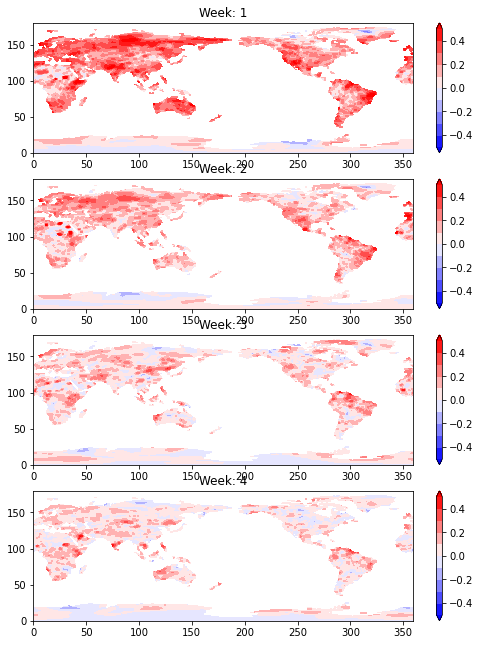

In [24]:
plt.figure(figsize=(8.5,11))
levs=np.arange(-0.5,0.6,0.1)
for iweek in np.arange(4):
    plt.subplot(4,1,iweek+1)
    plt.contourf(skill[varname][iweek,:,:],levs,cmap='bwr',extend='both')
    plt.title('Week: '+(iweek+1).astype(str))
    plt.colorbar()

### Write skill to file

In [25]:
outfile=base_path+model+'/hcst/skill/'+model+'.'+varname+'.acc.emean.DJF.1999-2015.nc'
skill.to_netcdf(outfile)

/glade/u/home/kpegion/miniconda3/envs/myenv/lib/python3.6/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/u/home/kpegion/miniconda3/envs/myenv/lib/python3.6/site-packages/xskillscore/core/np_deterministic.py:187: RuntimeWarning: invalid value encountered in true_divide
  r = r_num / r_den
